<a href="https://colab.research.google.com/github/akhilesh-reddyy/Fraud-Detection-System/blob/main/fraud_detection_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install pandas numpy scikit-learn psycopg2-binary shap matplotlib joblib


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

import shap


In [9]:
import pandas as pd

df = pd.read_csv('creditcard.csv')
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.74      0.84        98

    accuracy                           1.00     56962
   macro avg       0.98      0.87      0.92     56962
weighted avg       1.00      1.00      1.00     56962



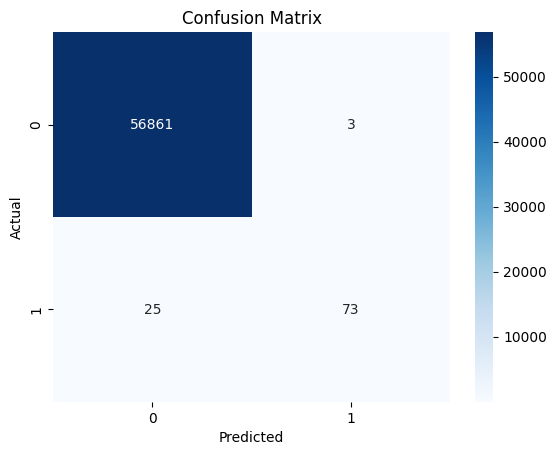

ROC-AUC: 0.952908497036969


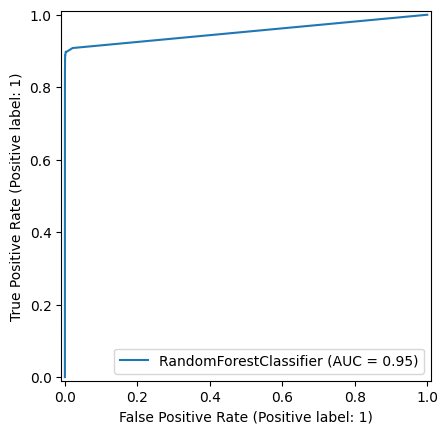

Class 0 shap_values shape: (30, 2)
Class 1 shap_values shape: (30, 2)
Class 2 shap_values shape: (30, 2)
Class 3 shap_values shape: (30, 2)
Class 4 shap_values shape: (30, 2)
Class 5 shap_values shape: (30, 2)
Class 6 shap_values shape: (30, 2)
Class 7 shap_values shape: (30, 2)
Class 8 shap_values shape: (30, 2)
Class 9 shap_values shape: (30, 2)
Class 10 shap_values shape: (30, 2)
Class 11 shap_values shape: (30, 2)
Class 12 shap_values shape: (30, 2)
Class 13 shap_values shape: (30, 2)
Class 14 shap_values shape: (30, 2)
Class 15 shap_values shape: (30, 2)
Class 16 shap_values shape: (30, 2)
Class 17 shap_values shape: (30, 2)
Class 18 shap_values shape: (30, 2)
Class 19 shap_values shape: (30, 2)
Class 20 shap_values shape: (30, 2)
Class 21 shap_values shape: (30, 2)
Class 22 shap_values shape: (30, 2)
Class 23 shap_values shape: (30, 2)
Class 24 shap_values shape: (30, 2)
Class 25 shap_values shape: (30, 2)
Class 26 shap_values shape: (30, 2)
Class 27 shap_values shape: (30, 2)
Cl

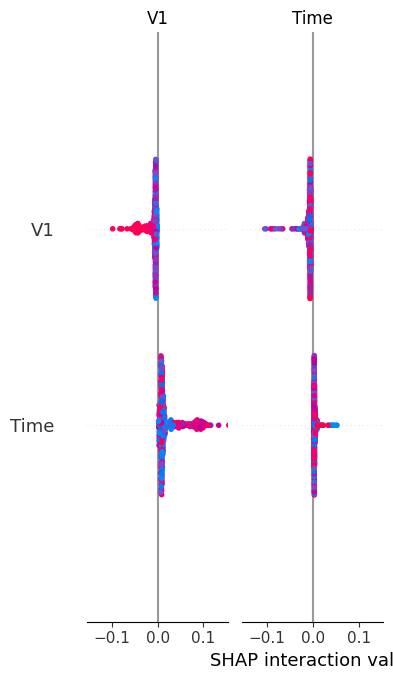

<Figure size 640x480 with 0 Axes>

In [10]:
# Preprocessing
# Features and target
# Drop rows where Class is NaN
df = df.dropna(subset=["Class"])

# Or if you want to fill NaNs just in case (not usually recommended for labels)
df["Class"] = df["Class"].fillna(0).astype(int)

# Now re-run preprocessing
X = df.drop("Class", axis=1)
y = df["Class"]


# Scale Amount & Time (other V1-V28 already PCA-transformed)
scaler = StandardScaler()
X[["Time", "Amount"]] = scaler.fit_transform(X[["Time", "Amount"]])

# Train-test split (stratified to handle imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train model
clf = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


# Metrics
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC-AUC
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
print("ROC-AUC:", roc_auc)

RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.show()



# SHAP for interpretability

# Use TreeExplainer for RandomForest
explainer = shap.TreeExplainer(clf)

# Compute SHAP values on a subset (keep DataFrame with column names)
subset = X_test.iloc[:500]
shap_values = explainer.shap_values(subset)

# Check the shapes
for i, sv in enumerate(shap_values):
    print(f"Class {i} shap_values shape:", sv.shape)

# If shap_values is a list → use shap_values[1] (fraud class)
if isinstance(shap_values, list):
    shap.summary_plot(shap_values[1], subset, plot_type="bar", show=True)
else:
    # Binary classification sometimes returns just an array instead of a list
    shap.summary_plot(shap_values, subset, plot_type="bar", show=True)

plt.savefig("shap_summary.png")
plt.close()



# Save plots
plt.savefig("confusion_matrix.png")
plt.savefig("roc_curve.png")

